In [2]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from rnn import RNNNet
from dataset import StimuliDataset

In [3]:
#loads the model
hidden_size = 128
input_size = 13
output_size = 6
dt = 0.1
tau = 100
batch_size = 1
model_path = './model.pt'
num_trials = 500
net = RNNNet(input_size=input_size, hidden_size=hidden_size, output_size=output_size, dt=dt, tau=tau)
net.load_state_dict(torch.load(model_path))
# Check if a GPU is available
device = torch.device("cpu")

# Move the network to the device
net = net.to(device)

print(num_trials)
dataset = StimuliDataset(num_trials)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

500


In [5]:
stimulus_activity_dict = {}
decision_activity_dict = {}
attended_info = {}
for i, (stimulus, labels) in enumerate(dataloader):
            labels = torch.tensor(labels.squeeze(-1), dtype=torch.int64)
            stimuli = np.stack([stimulus] * 3, axis=1)
            stop_cue = np.zeros((batch_size,1,input_size))
            inputs  = np.concatenate((stimuli, stop_cue), axis=1)
            attended_info[i] = inputs[0][0][-1] #records the trial-specific attentional cue
            inputs = torch.from_numpy(inputs).float().to(device)
            labels = labels.float().to(device)  # Convert labels to long and move to device

            output, rnn_activity = net(inputs.permute(1, 0, 2))
            rnn_activity = rnn_activity[:, 0, :].detach().numpy()
            stimulus_activity_dict[i] = rnn_activity[:3][:]
            decision_activity_dict[i] = np.expand_dims(rnn_activity[-1][:], axis=0)
print("finished")

/tmp/ipykernel_19436/430791895.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels.squeeze(-1), dtype=torch.int64)


finished


In [6]:
attended_trials_stimulus = []
attended_trials_decision = []
unattended_trials_stimulus = []
unattended_trials_decision = []
for i in range(len(attended_info)):
        if (attended_info[i] > 0):
                attended_trials_stimulus.append(stimulus_activity_dict[i])
                attended_trials_decision.append(decision_activity_dict[i])
        else:
                unattended_trials_stimulus.append(stimulus_activity_dict[i])
                unattended_trials_decision.append(decision_activity_dict[i])
                
                
attended_trials_num = len(attended_trials_stimulus)
unattended_trials_num = len(unattended_trials_stimulus)

attended_trials_stimulus = np.concatenate(list(attended_trials_stimulus[i] for i in range(attended_trials_num)), axis=0)
print(attended_trials_stimulus.shape)
attended_trials_decision = np.concatenate(list(attended_trials_decision[i] for i in range(attended_trials_num)), axis=0)
unattended_trials_stimulus = np.concatenate(list(unattended_trials_stimulus[i] for i in range(unattended_trials_num)), axis=0)
unattended_trials_decision = np.concatenate(list(unattended_trials_decision[i] for i in range(unattended_trials_num)), axis=0)

(735, 128)


In [10]:
# Compute PCA and visualize
from sklearn.decomposition import PCA

pca_attended_stimulus = PCA(n_components=6)
pca_attended_stimulus.fit(attended_trials_stimulus)

pca_unattended_stimulus = PCA(n_components=6)
pca_unattended_stimulus.fit(unattended_trials_stimulus)

PCA(n_components=6)

Text(0, 0.5, 'PC 1')

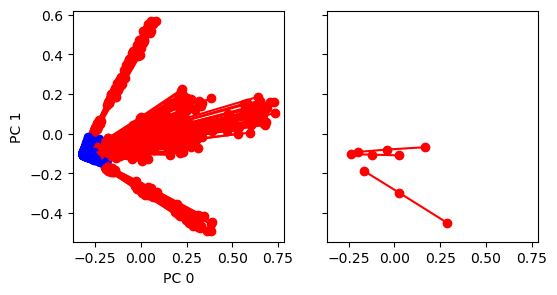

In [19]:
#pca'ed using attended (stimulus) trials, projecting all trials onto attended pca space
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(6, 3))
for i in range(num_trials):
    attended_stimulus_activity_pc = pca_attended_stimulus.transform(stimulus_activity_dict[i]) # project the trial i's neural activity onto the first 6 PCs
    color = 'red' if attended_info[i] > 0 else 'blue'

    _ = ax1.plot(attended_stimulus_activity_pc[:, 0], attended_stimulus_activity_pc[:, 1], 'o-',color = color)

    if i < 3:
        _ = ax2.plot(attended_stimulus_activity_pc[:, 0], attended_stimulus_activity_pc[:, 1], 'o-', color=color)

ax1.set_xlabel('PC 0')
ax1.set_ylabel('PC 1')

Text(0, 0.5, 'PC 1')

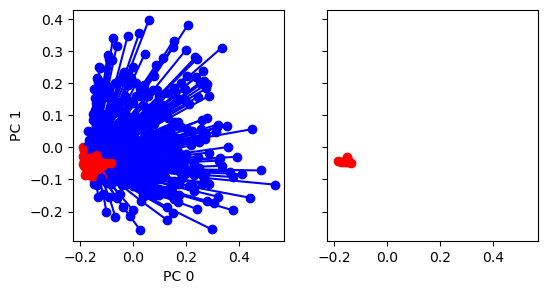

In [20]:
#pca'ed using unattended (stimulus) trials, projecting all trials onto unattended pca space
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(6, 3))
for i in range(num_trials):
    unattended_stimulus_activity_pc = pca_unattended_stimulus.transform(stimulus_activity_dict[i]) # project the trial i's neural activity onto the first 6 PCs
    color = 'red' if attended_info[i] > 0 else 'blue'

    _ = ax1.plot(unattended_stimulus_activity_pc[:, 0], unattended_stimulus_activity_pc[:, 1], 'o-',color = color)

    if i < 3:
        _ = ax2.plot(unattended_stimulus_activity_pc[:, 0], unattended_stimulus_activity_pc[:, 1], 'o-', color=color)

ax1.set_xlabel('PC 0')
ax1.set_ylabel('PC 1')

In [7]:
# Compute PCA and visualize
from sklearn.decomposition import PCA

pca_attended_decision = PCA(n_components=6)
pca_attended_decision.fit(attended_trials_decision)

pca_unattended_decision = PCA(n_components=6)
pca_unattended_decision.fit(unattended_trials_decision)

PCA(n_components=6)

Text(0, 0.5, 'PC 1')

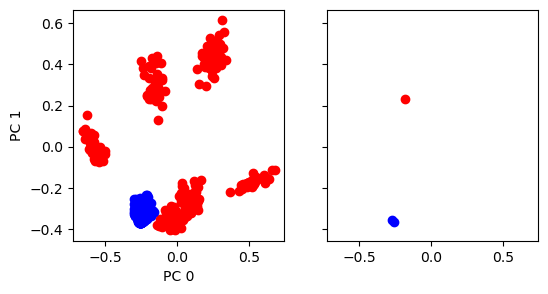

In [8]:
#pca'ed using attended (decision) trials, projecting all trials onto attended pca space
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(6, 3))
for i in range(num_trials):
    attended_decision_activity_pc = pca_attended_decision.transform(decision_activity_dict[i]) # project the trial i's neural activity onto the first 6 PCs
    color = 'red' if attended_info[i] > 0 else 'blue'

    _ = ax1.plot(attended_decision_activity_pc[:, 0], attended_decision_activity_pc[:, 1], 'o-',color = color)

    if i < 3:
        _ = ax2.plot(attended_decision_activity_pc[:, 0], attended_decision_activity_pc[:, 1], 'o-', color=color)

ax1.set_xlabel('PC 0')
ax1.set_ylabel('PC 1')

Text(0, 0.5, 'PC 1')

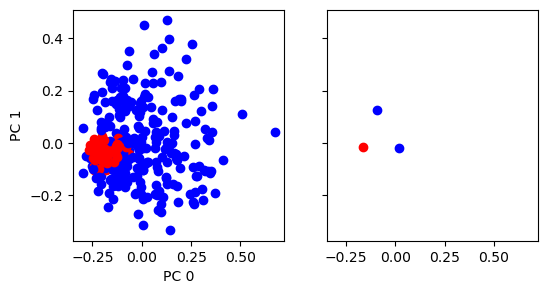

In [9]:
#pca'ed using unattended (decision) trials, projecting all trials onto unattended pca space
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(6, 3))
for i in range(num_trials):
    unattended_decision_activity_pc = pca_unattended_decision.transform(decision_activity_dict[i]) # project the trial i's neural activity onto the first 6 PCs
    color = 'red' if attended_info[i] > 0 else 'blue'

    _ = ax1.plot(unattended_decision_activity_pc[:, 0], unattended_decision_activity_pc[:, 1], 'o-',color = color)

    if i < 3:
        _ = ax2.plot(unattended_decision_activity_pc[:, 0], unattended_decision_activity_pc[:, 1], 'o-', color=color)

ax1.set_xlabel('PC 0')
ax1.set_ylabel('PC 1')